## Maximize the likelihood for different values of H_0

First, I create a mock P1D measurement with the covariance matrix of Chabanier et al. (2019, eBOSS DR14), but with the data vector from a Gadget simulation with a Hubble parameter from SHOES ($H_0$ = 74 km/s/Mpc).

Then I setup an emulator with our suite of 30 simulations, all of which ran with $H_0$ = 67 km/s/Mpc.

Finally, I setup a likelihood object with several free parameters: 3 cosmological parameters ($A_s$,$n_s$,$H_0$) and 3 IGM parameters (overall normalization of $<F>$, $T_0$ and $\gamma$, fixed redshift evolution).

I choose then 15 values of Hubble parameter in the range $55.0 < H_0 < 90$ km/s/Mpc, and for each of these I maximize the likelihood with iminuit, and report the best-fit values, Gaussian errorbars and $\chi^2$.

We show that only for extreme values of $H_0$ our best-fit $\chi^2$ changes by one.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['savefig.dpi'] = 140
mpl.rcParams['figure.dpi'] = 140
import numpy as np
from iminuit import Minuit
# our modules
import camb_cosmo
import CAMB_model
import full_theory
import likelihood
import data_MPGADGET
import gp_emulator
import p1d_arxiv

Setup mock data, from one of simulations in the suite

In [2]:
# specify simulation to use to generate synthetic data
test_sim_label='h'
if type(test_sim_label)==int:
    drop_sim_number=test_sim_label
    print('will drop sim number {} from emulator'.format(drop_sim_number))
else:
    drop_sim_number=None

In [3]:
# specify simulation suite and P1D mesurements
basedir="/p1d_emulator/sim_suites/Australia20/"
skewers_label='Ns500_wM0.05'
p1d_label=None
z_max=4.0
data=data_MPGADGET.P1D_MPGADGET(basedir=basedir,
                                skewers_label=skewers_label,
                                sim_label=test_sim_label,
                                zmax=z_max)

read cosmology from GenIC /Users/font/Projects/LyaCosmoParams//p1d_emulator/sim_suites/Australia20/h_sim/sim_plus/paramfile.genic
H0 = 7.4000E+01, Omega_b h^2 = 2.2000E-02, Omega_c h^2 = 1.2000E-01, Omega_k = 0.0000E+00, Omega_nu h^2 = 0.0000E+00, A_s = 2.0138E-09, n_s = 9.6756E-01, alpha_s = 0.0000E+00


Setup archive of P1D measurements from simulations to train the emulator

In [4]:
# specify redshift range
z_max=4
arxiv=p1d_arxiv.ArxivP1D(basedir=basedir,drop_sim_number=drop_sim_number,
                            drop_tau_rescalings=True,z_max=z_max,
                            drop_temp_rescalings=True,skewers_label=skewers_label)

In [5]:
# specify parameters to be used in emulator
paramList=['mF', 'sigT_Mpc', 'gamma', 'kF_Mpc', 'Delta2_p', 'n_p']
# specify k range
kmax_Mpc=8
# setup GP emulator
emu=gp_emulator.GPEmulator(basedir,p1d_label,skewers_label,z_max=z_max,
                                verbose=False,paramList=paramList,train=False,
                                emu_type="k_bin",passArxiv=arxiv,kmax_Mpc=kmax_Mpc)
emu.load_default()

 /Library/Python/3.7/site-packages/paramz/parameterized.py:61: RuntimeWarning:Don't forget to initialize by self.initialize_parameter()!


In [6]:
# get true cosmology in test simulation
sim_cosmo=data.mock_sim.sim_cosmo
true_As=sim_cosmo.InitPower.As
true_ns=sim_cosmo.InitPower.ns
true_H0=sim_cosmo.H0
true_mnu=camb_cosmo.get_mnu(sim_cosmo)
print('true As =',true_As)
print('true ns =',true_ns)
print('true H_0 =',true_H0)
print('true mnu =',true_mnu)

true As = 2.013797e-09
true ns = 0.967556
true H_0 = 74.0
true mnu = 0.0


### Maximize likelihood for different values of H_0

In [7]:
# define free likelihood parameters
like_params=["As","ns","ln_tau_0","ln_sigT_kms_0","ln_gamma_0"]
like_param_limits=[[1.0e-9,3.0e-9 ], [0.90, 1.05],[-0.2, 0.2], [-0.5, 0.5], [-0.2, 0.2]]
# choose starting point
theta=np.ones(len(like_params))*0.5

In [8]:
NH0=15
H0s=np.linspace(55.0,90.0,NH0)
likelihoods=[]
for H0 in H0s:
    cosmo_fid=camb_cosmo.get_cosmology(H0=H0)
    camb_model_fid=CAMB_model.CAMBModel(zs=data.z,cosmo=cosmo_fid)
    theory=full_theory.FullTheory(zs=data.z,emulator=emu,camb_model_fid=camb_model_fid)
    print('use fiducial cosmology with H0=',H0)
    like=likelihood.Likelihood(data=data,theory=theory,
                            free_param_names=like_params,
                            free_param_limits=like_param_limits,
                            verbose=False,prior_Gauss_rms=0.5)
    likelihoods.append(like)

use fiducial cosmology with H0= 55.0
use fiducial cosmology with H0= 57.5
use fiducial cosmology with H0= 60.0
use fiducial cosmology with H0= 62.5
use fiducial cosmology with H0= 65.0
use fiducial cosmology with H0= 67.5
use fiducial cosmology with H0= 70.0
use fiducial cosmology with H0= 72.5
use fiducial cosmology with H0= 75.0
use fiducial cosmology with H0= 77.5
use fiducial cosmology with H0= 80.0
use fiducial cosmology with H0= 82.5
use fiducial cosmology with H0= 85.0
use fiducial cosmology with H0= 87.5
use fiducial cosmology with H0= 90.0


In [9]:
results=[]
for like in likelihoods:
    ## Evaluate log_prob at random point in parameter space
    chi2_test=like.get_chi2(theta)
    print('starting chi2',chi2_test)
    # setup minuit
    m = Minuit.from_array_func(like.minus_log_prob,theta,error=0.02,errordef=0.5)
    # run optimiser
    m.migrad()
    # compute Hesse covariance
    m.hesse()
    # store results from iminuit
    results.append(m)
    min_chi2=like.get_chi2(m.values)
    print('minimum chi2',min_chi2)

starting chi2 5.707243954275073
minimum chi2 1.2115779942171152
starting chi2 6.183169738485445
minimum chi2 0.9737490957483704
starting chi2 6.846837008737096
minimum chi2 0.773986433169359
starting chi2 7.712473944069732
minimum chi2 0.6151608046537063
starting chi2 8.786832147515064
minimum chi2 0.5022446568739846
starting chi2 10.067690497282037


 /Library/Python/3.7/site-packages/numpy/linalg/linalg.py:2099: RuntimeWarning:invalid value encountered in slogdet


minimum chi2 0.4361526463291432
starting chi2 11.543123738735783
minimum chi2 0.4198893426367706
starting chi2 13.191369117504435
minimum chi2 0.44626912295569515
starting chi2 14.98339523043857
minimum chi2 0.5040677736485006
starting chi2 16.88578190642411
minimum chi2 0.592550162793768
starting chi2 18.864999194123186
minimum chi2 0.7105558952591168
starting chi2 20.889526224592768
minimum chi2 0.8521936327562125
starting chi2 22.93397209340288
minimum chi2 1.0402887523009807
starting chi2 24.978369426017018
minimum chi2 1.2938933472403151
starting chi2 27.00696255879073
minimum chi2 1.6240059191365033


In [10]:
best_fit_chi2=[likelihoods[p].get_chi2(values=results[p].values) for p in range(NH0)]
best_fit_As=[likelihoods[p].parameters_from_sampling_point(results[p].values)[0].value for p in range(NH0)]
best_fit_ns=[likelihoods[p].parameters_from_sampling_point(results[p].values)[1].value for p in range(NH0)]

In [11]:
# convoluted way to get error on As and ns
error_As=[likelihoods[p].parameters_from_sampling_point(results[p].np_values()+results[p].np_errors())[0].value - best_fit_As[p] for p in range(NH0) ]
error_ns=[likelihoods[p].parameters_from_sampling_point(results[p].np_values()+results[p].np_errors())[1].value - best_fit_ns[p] for p in range(NH0) ]

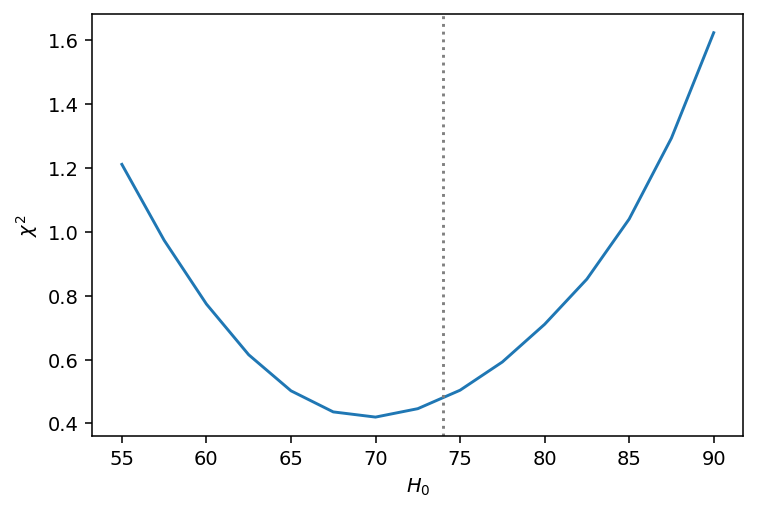

In [12]:
plt.plot(H0s,best_fit_chi2)
plt.axvline(x=sim_cosmo.H0,ls=':',color='gray')
plt.xlabel(r'$H_0$')
plt.ylabel(r'$\chi^2$');

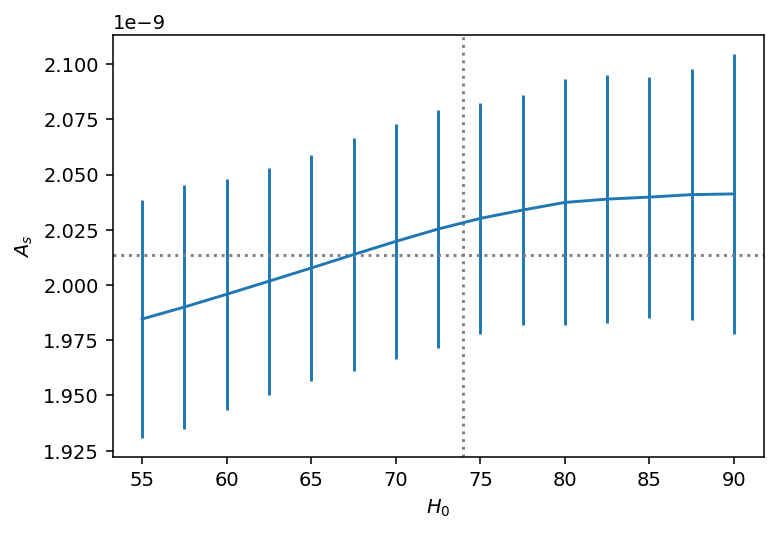

In [13]:
plt.errorbar(H0s,best_fit_As,yerr=error_As)
plt.axvline(x=sim_cosmo.H0,ls=':',color='gray')
plt.axhline(y=sim_cosmo.InitPower.As,ls=':',color='gray')
plt.xlabel(r'$H_0$')
plt.ylabel(r'$A_s$');

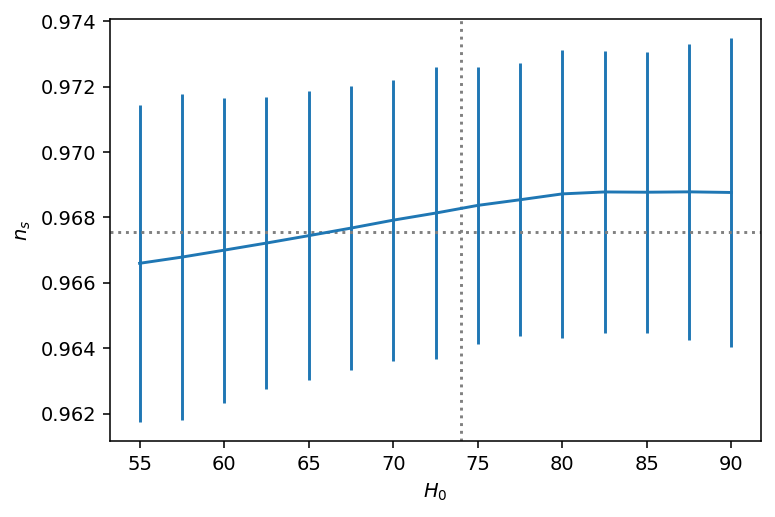

In [14]:
plt.errorbar(H0s,best_fit_ns,yerr=error_ns)
plt.axvline(x=sim_cosmo.H0,ls=':',color='gray')
plt.axhline(y=sim_cosmo.InitPower.ns,ls=':',color='gray')
plt.xlabel(r'$H_0$')
plt.ylabel(r'$n_s$');